# CNN For Predicting Welding Quality

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import util
from config import *
from cnn import Cnn
%matplotlib inline

## Prepare data

Data is a three-dimensional time series consisting of **electrode position, current, and voltage**

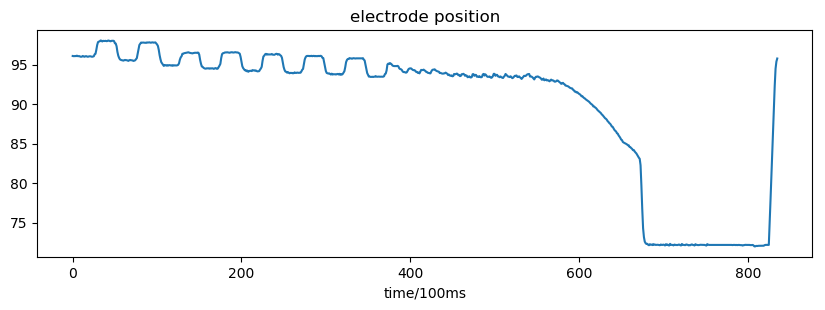

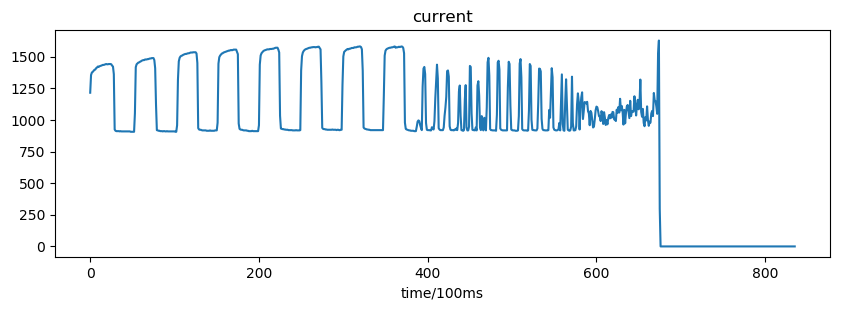

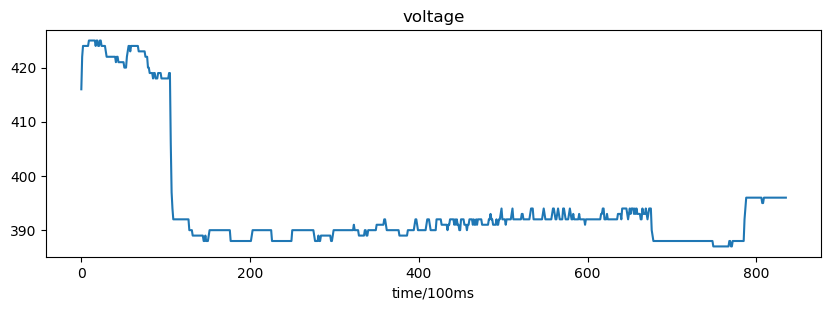

In [2]:
data, num1, num2 = util.load_data(False)
plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('electrode position')
plt.plot(data[0][:, 0])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('current')
plt.plot(data[0][:, 1])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('voltage')
plt.plot(data[0][:, 2])

plt.show()

We use downsampling to make the sequences equal in length. It can be seen that after downsampling to a length of 600, there is not much loss in the characteristics of the data.

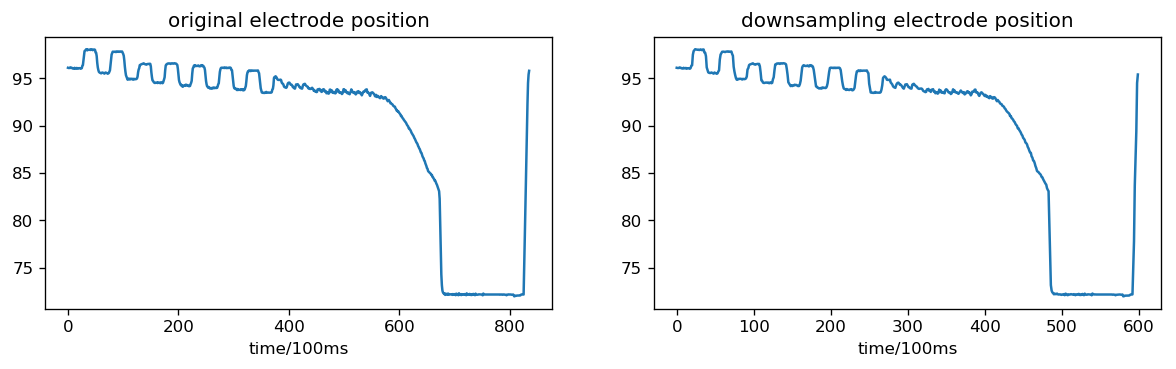

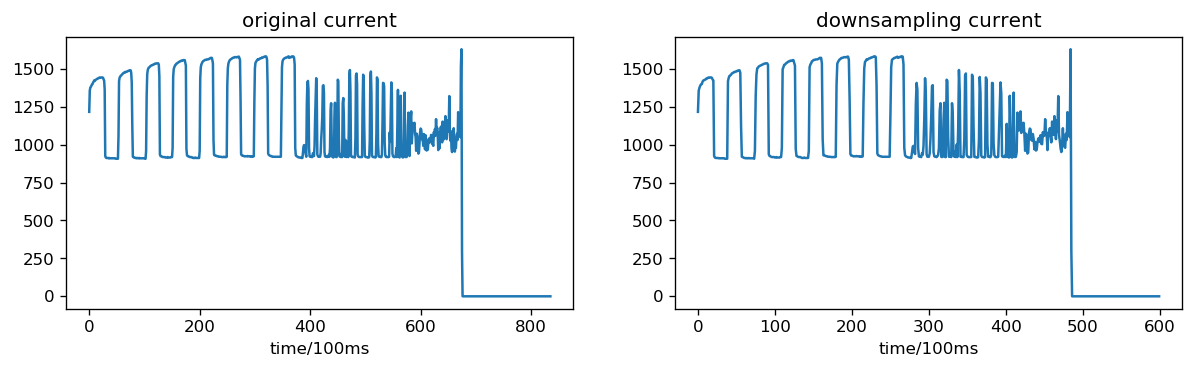

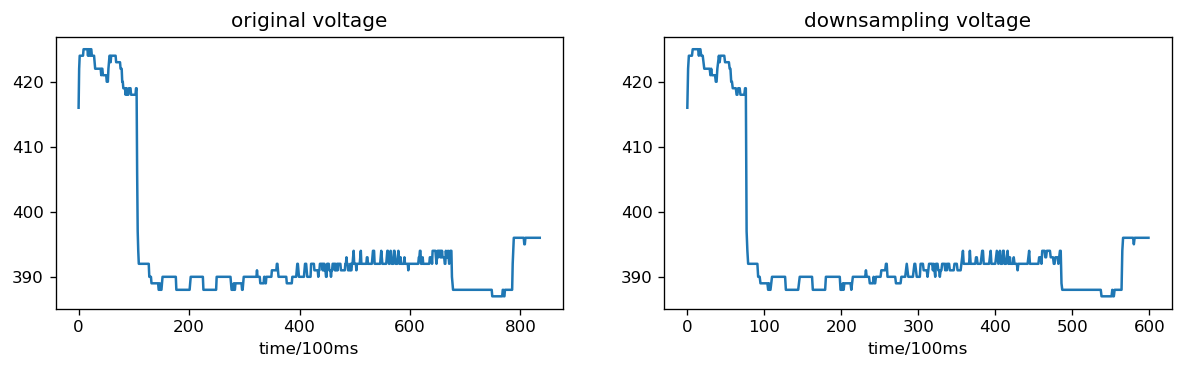

In [3]:
data2, length = util.resample(data, 600)
plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original electrode position')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 0])
plt.subplot(122)
plt.title('downsampling electrode position')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 0])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original current')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 1])
plt.subplot(122)
plt.title('downsampling current')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 1])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original voltage')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 2])
plt.subplot(122)
plt.title('downsampling voltage')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 2])

plt.show()

Now, we start data processing.

In [4]:
data, num_good, num_bad = util.load_data(50)

# resample and regularize
data, length = util.resample(data, 600)
data = util.reshape(data, length)
for i in range(len(data)):
    data[i, :, 0] = util.regularize(data[i, :, 0])
    data[i, :, 1] = util.regularize(data[i, :, 1])
    data[i, :, 2] = util.regularize(data[i, :, 2])
train_x, train_y, test_x, test_y = util.shuffle_data(data, num_good, num_bad, 0.3)

# Hyperparameters

In [5]:
# numbers of neurons in each convolution layer, 0 is the max pool, -1 is the dropout
conv_layers = [18, 0, 36, 0, 72, -1, 0, 144]

# (filter size, step, pad) in filters in each layers. For pad, fill in 'SAME' or 'VALID'.
# Must correspond to conv_layers. If it is dropout, fill with 0
filters = [(2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), 0, (2, 2, 'SAME'),
           (2, 1, 'SAME')]

# the dims of full connected layers. The last layer is 1 and you do not need to write it on. Already implement dropout.
fc_layers = []

learning_rate = 0.000075

num_epochs = 300

# 0->disable
mini_batch_size = 0

# dropout
keep_prob = 0.5

## Construct CNN

In [6]:
graph = tf.Graph()

with graph.as_default():
    cnn = Cnn(conv_layers, fc_layers, filters, learning_rate)
    (m, n_W0, n_C0) = train_x.shape
    n_y = train_y.shape[1]
    
    cnn.initialize(n_W0, n_C0, n_y)
    cnn.forward()
    cost = cnn.cost()
    optimizer = cnn.get_optimizer(cost)
    predict, accuracy = cnn.predict()

## Train

In [7]:
# log the cost and accuracy
cost_log = []
test_log = []
train_log = []
x = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1, num_epochs + 1):
        if mini_batch_size != 0:
            num_mini_batches = int(m / mini_batch_size)
            mini_batches = util.random_mini_batches(train_x, train_y, mini_batch_size)

            cost_value = 0
            for mini_batch in mini_batches:
                (mini_batch_x, mini_batch_y) = mini_batch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={cnn.x: mini_batch_x, cnn.y: mini_batch_y, cnn.keep_prob: keep_prob})
                cost_value += temp_cost
            cost_value /= num_mini_batches
        else:
            _, cost_value = sess.run([optimizer, cost], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: keep_prob})

        # disable dropout
        train_accuracy, output = sess.run([accuracy, predict], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: 1})
        test_accuracy = sess.run(accuracy, feed_dict={cnn.x: test_x, cnn.y: test_y, cnn.keep_prob: 1})

        cost_log.append(cost_value)
        train_log.append(train_accuracy)
        test_log.append(test_accuracy)
        x.append(i)

        if print_detail and (i % 10 == 0 or i == 1):
            print('Iteration '+str(i))
            print('Cost: '+str(cost_value))
            print('Train accuracy: '+str(train_accuracy))
            print('Test accuracy: '+str(test_accuracy))
            print()

Iteration 1
Cost: 0.70579606
Train accuracy: 0.4857143
Test accuracy: 0.53333336

Iteration 10
Cost: 0.60372984
Train accuracy: 0.4857143
Test accuracy: 0.53333336

Iteration 20
Cost: 0.50663716
Train accuracy: 0.4857143
Test accuracy: 0.53333336

Iteration 30
Cost: 0.39542776
Train accuracy: 0.78571427
Test accuracy: 0.76666665

Iteration 40
Cost: 0.32339197
Train accuracy: 0.94285715
Test accuracy: 0.8

Iteration 50
Cost: 0.26144245
Train accuracy: 0.95714283
Test accuracy: 0.9

Iteration 60
Cost: 0.20205659
Train accuracy: 0.95714283
Test accuracy: 0.9

Iteration 70
Cost: 0.15132684
Train accuracy: 0.95714283
Test accuracy: 0.9

Iteration 80
Cost: 0.108959824
Train accuracy: 0.98571426
Test accuracy: 0.93333334

Iteration 90
Cost: 0.08528387
Train accuracy: 0.98571426
Test accuracy: 0.93333334

Iteration 100
Cost: 0.06553388
Train accuracy: 0.98571426
Test accuracy: 0.93333334

Iteration 110
Cost: 0.08260705
Train accuracy: 0.98571426
Test accuracy: 0.93333334

Iteration 120
Cost: 0

## Chart

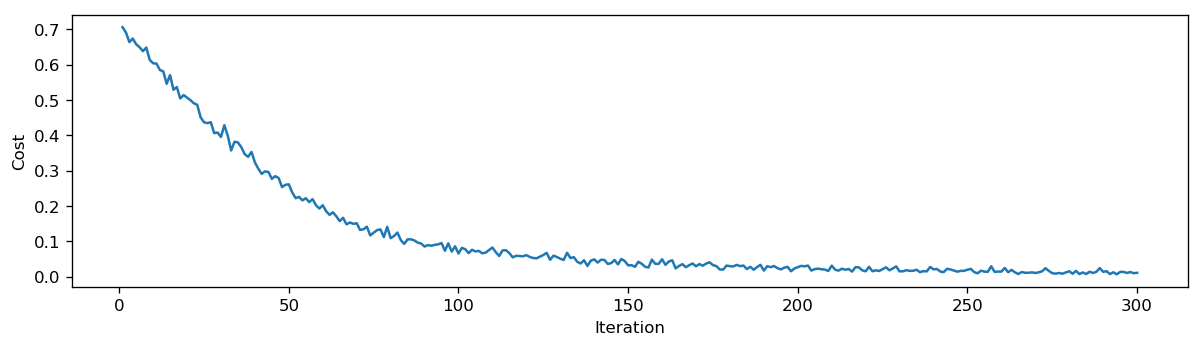

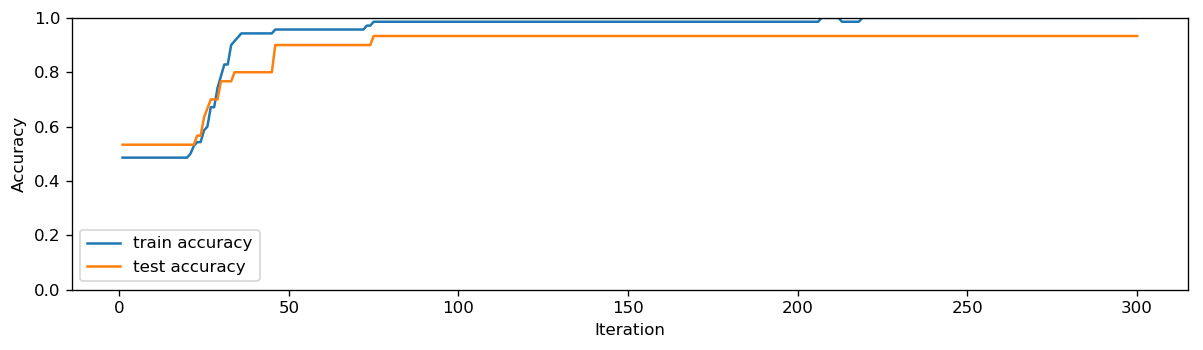

In [8]:
plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.plot(x, cost_log)

plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.plot(x, train_log, label='train accuracy')
plt.plot(x, test_log, label='test accuracy')
plt.legend()

plt.show()